Libraries

In [2]:
# Load libraries
import os
import numpy
import itertools
from time import time
from tqdm import tqdm

import torch
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchvision.transforms import transforms

Mount to Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# checks which device you are using 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
print(device)

cuda




Transformations/Augmentations



In [6]:
#Transforms & Augmentations

tfm = {
    'train':  transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomCrop((224,224)),
        transforms.ColorJitter(brightness= 0, contrast=0, saturation=0),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((-25,+25)), # -25 to 25 degress from Y axis
        transforms.ToTensor(),
        transforms.Normalize([0.5303,0.5303,0.5303], [0.1944,0.1944, 0.1944]) # mean, std of the dataset
]),
'validation':  transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5303,0.5303,0.5303], [0.1944,0.1944, 0.1944])
]),
'test':  transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5303,0.5303,0.5303], [0.1944,0.1944, 0.1944])
])
}  
    
    

Load Dataset

In [7]:
train_path = '/content/drive/MyDrive/chest_xray/train'
validation_path = '/content/drive/MyDrive/chest_xray/val'
test_path = '/content/drive/MyDrive/chest_xray/test'

train_dataset = ImageFolder(train_path, transform=tfm['train'])
validation_dataset = ImageFolder(validation_path, transform=tfm['validation'])
test_dataset = ImageFolder(test_path, transform=tfm['test'])

train_loader=DataLoader(train_dataset, batch_size= 32, shuffle=True)
validation_loader=DataLoader(validation_dataset, batch_size= 16, shuffle=False) #validation set is 16 images
test_loader=DataLoader(test_dataset, shuffle=False)


train_dataset_size = len(train_dataset)
validation_dataset_size = len(validation_dataset)
test_dataset_size = len(test_dataset)

print(train_dataset_size)
print(validation_dataset_size)
print(test_dataset_size)

5216
16
624


ResNet-18 Model Intialization

In [9]:
model = resnet18(weights='ResNet18_Weights.DEFAULT') # Loading pretrained weights from ImageNet
num_features = model.fc.in_features
model.fc = Linear(in_features= num_features, out_features = 2)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Optimizer & Loss function

In [32]:
optimizer = Adam(model.parameters(), lr = 0.0001)
loss_function = CrossEntropyLoss()

Training and Evaluation

In [33]:
# Key statistics for calculating metrics like precision, accuracy, recall, etc 
false_negative_pred = 0
false_positive_pred = 0 
true_positive_pred = 0
true_negative_pred = 0


tr_a = [] # saves training accuracy per epoch 
va_a = [] # saves validation accuracy per epoch  
te_a = [] # saves test accuracy per epoch 
tr_l = [] # saves training loss per epoch 

num_epochs = 5
for epoch in range(num_epochs):
  start = time()

  training_accuracy = 0
  validation_accuracy = 0 
  test_accuracy = 0

  # Training
  model.train()

  with tqdm(train_loader, unit="batch") as tepoch:
    for xtrain, ytrain in tepoch:
      optimizer.zero_grad() #gradients set to 0

      xtrain = xtrain.to(device)
      train_prob = model(xtrain) # run model on inputs
      train_prob = train_prob.cpu()

      loss = loss_function(train_prob, ytrain) # calculate loss
      loss.backward() #backprop
      optimizer.step()

      train_pred = torch.max(train_prob, 1).indices # prediction results
      training_accuracy += int(torch.sum(train_pred == ytrain)) # count the number of correct predictions in batch


    ep_tr_acc = training_accuracy / train_dataset_size # calculate training accuracy

  
  # Evaluation 
  model.eval()

  # Validation set calculations
  with torch.no_grad():
    for xval, yval in validation_loader:
      xval = xval.to(device)
      val_prob = model(xval)
      val_prob = val_prob.cpu()

      val_pred = torch.max(val_prob, 1).indices
      validation_accuracy += int(torch.sum(val_pred == yval))

    ep_val_acc = validation_accuracy / validation_dataset_size

  
  # Test set calculations
  with torch.no_grad():
    for xtest, ytest in test_loader:
      xtest = xtest.to(device)
      test_prob = model(xtest)
      test_prob = test_prob.cpu()

      test_pred = torch.max(test_prob, 1).indices
      test_accuracy += int(torch.sum(test_pred == ytest))

      if epoch == (num_epochs-1): # Save statistics from the last epoch 
        pred_list = test_pred.tolist() # Convert tensors to list 
        actual_list = ytest.tolist()

        for (pred, actual) in zip(pred_list, actual_list): # False Negative counter
          if actual == 1 and pred != actual:
            false_negative_pred = false_negative_pred + 1
      
          elif actual == 1 and pred == actual:  # True Positive counter
            true_positive_pred = true_positive_pred + 1

      
          elif actual == 0 and pred != actual: # False Positive counter
            false_positive_pred = false_positive_pred + 1

          else: # True Negative counter
            true_negative_pred = true_negative_pred + 1


    ep_test_acc = test_accuracy / test_dataset_size


  end = time()
  duration = (end - start) / 60
  
  # Print epoch data 
  print(f"Epoch: {epoch}, Time: {duration}, Loss: {loss}\nTrain_acc: {ep_tr_acc}({training_accuracy}/{train_dataset_size}), Val_acc: {ep_val_acc}({validation_accuracy}/{validation_dataset_size})")
  print(f"Test_acc: {ep_test_acc}({test_accuracy}/\n{test_dataset_size})\n")
  
  # Save epoch data
  tr_a.append(ep_tr_acc)
  va_a.append(ep_val_acc)
  te_a.append(ep_test_acc)
  tr_l.append(loss)


100%|██████████| 163/163 [01:49<00:00,  1.49batch/s]


Epoch: 0, Time: 2.0632766683896384, Loss: 0.03299155458807945
Train_acc: 0.9831288343558282(5128/5216), Val_acc: 0.875(14/16)
Test_acc: 0.8589743589743589(536/
624)



100%|██████████| 163/163 [01:48<00:00,  1.50batch/s]


Epoch: 1, Time: 2.0527915080388386, Loss: 0.1325448900461197
Train_acc: 0.9860046012269938(5143/5216), Val_acc: 0.875(14/16)
Test_acc: 0.8413461538461539(525/
624)



100%|██████████| 163/163 [01:49<00:00,  1.49batch/s]


Epoch: 2, Time: 2.059904666741689, Loss: 0.01485507283359766
Train_acc: 0.9881134969325154(5154/5216), Val_acc: 1.0(16/16)
Test_acc: 0.8477564102564102(529/
624)



100%|██████████| 163/163 [01:49<00:00,  1.49batch/s]


Epoch: 3, Time: 2.064146049817403, Loss: 0.022058766335248947
Train_acc: 0.9886886503067485(5157/5216), Val_acc: 0.875(14/16)
Test_acc: 0.8525641025641025(532/
624)



100%|██████████| 163/163 [01:49<00:00,  1.49batch/s]


Epoch: 4, Time: 2.0617646257082622, Loss: 0.014132199808955193
Train_acc: 0.9896472392638037(5162/5216), Val_acc: 0.875(14/16)
Test_acc: 0.8221153846153846(513/
624)



Accuracy Graph

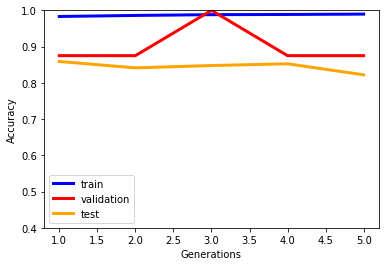

In [34]:
# Plot accuracy data 

import matplotlib.pyplot as plt

# generations = 5 
x = [1,2,3,4,5]


plt.xlabel('Generations')
plt.ylabel('Accuracy')
plt.plot(x,tr_a, color='blue', linewidth = 3,  label = 'train')
plt.plot(x,va_a, color='red', linewidth = 3,  label = 'validation')
plt.plot(x,te_a, color='orange', linewidth = 3,  label = 'test')
plt.legend()
plt.ylim([0.4, 1])
plt.show()

Graph training loss

[0.03299155458807945, 0.1325448900461197, 0.01485507283359766, 0.022058766335248947, 0.014132199808955193]


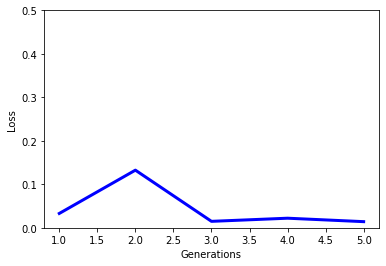

In [35]:
training_loss = [tensor.item() for tensor in tr_l]
print(training_loss)

plt.xlabel('Generations')
plt.ylabel('Loss')
plt.plot(x,training_loss, color='blue', linewidth = 3,  label = 'train_loss')
plt.ylim([0, 0.5])
plt.show()

Convert Tensor to Image for Visualization

In [36]:
# Credits to:  https://www.kaggle.com/code/ernestomaisuls/pytorch-data-augmentation

def convert_image(t):
    image = t.cpu().clone().detach().numpy()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image.clip(0, 1)
    return image

Visualization of Failure Cases

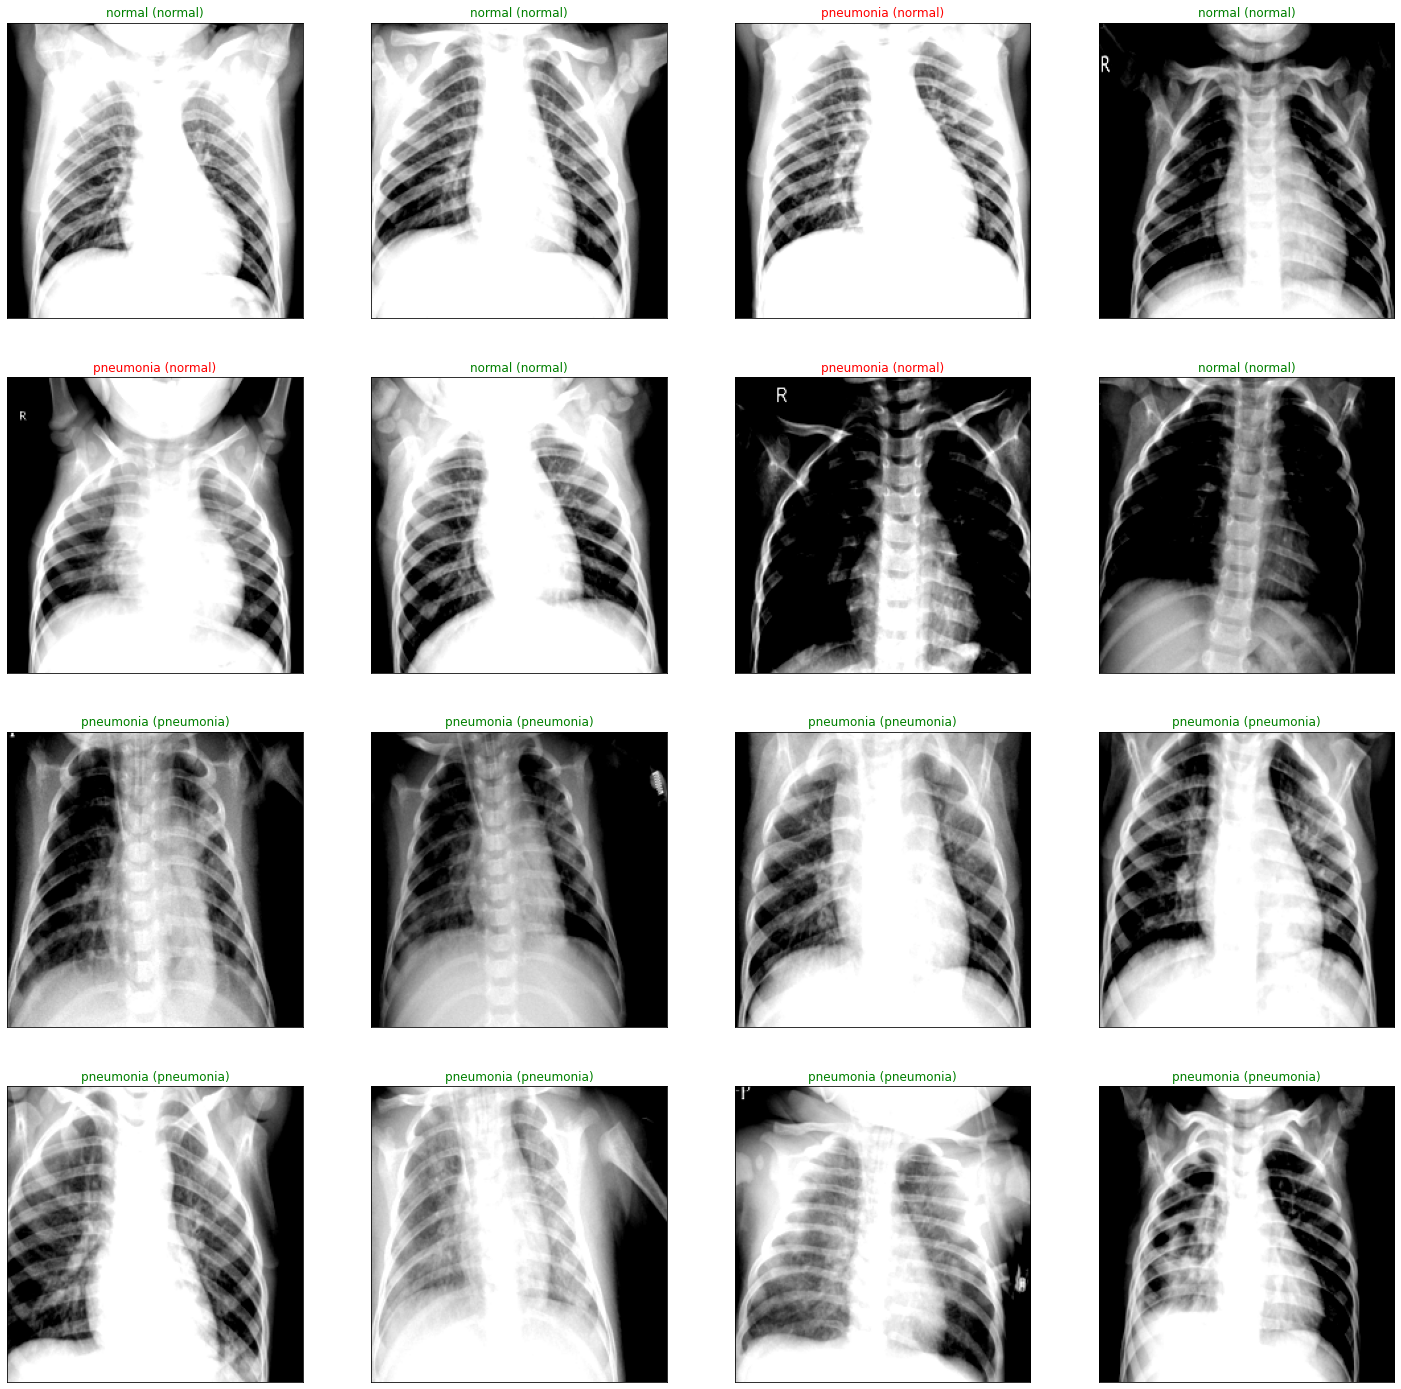

In [37]:
# Credits to:  https://www.kaggle.com/code/ernestomaisuls/pytorch-data-augmentation

import numpy as np 

Classes = ("normal", "pneumonia") # Two classes of images

dataiterator = iter(validation_loader) # Run on validation test set
images, labels = next(dataiterator)
images = images.to(device)
labels = labels.to(device)

output = model(images) # Evaluate model on images

_, preds = torch.max(output, 1)
fig =plt.figure(figsize =(25,25))


for i in np.arange(16): # 16 images

    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[]) # 4 by 4 plot 
    plt.imshow(convert_image(images[i]))
    ax.set_title("{} ({})".format(str(Classes[preds[i].item()]), str(Classes[labels[i].item()])),
               color =("red" if preds[i]!=labels[i] else "green")) # red if wrong, otherwise green

Calculations of Key Metrics 

In [38]:
accuracy = (true_positive_pred + true_negative_pred)/(false_negative_pred +false_positive_pred +true_positive_pred+true_negative_pred)
specificity = (true_negative_pred) / (false_positive_pred  + true_negative_pred)
precision = (true_positive_pred)/(true_positive_pred + false_positive_pred )
recall = true_positive_pred/(true_positive_pred + false_negative_pred)
f1 = 2 * (precision*recall)/(precision+recall)

print(false_negative_pred)
print(false_positive_pred)
print(true_positive_pred)
print(true_negative_pred)

print(accuracy)
print(specificity)
print(precision)
print(recall)
print(f1)

1
110
389
124
0.8221153846153846
0.5299145299145299
0.779559118236473
0.9974358974358974
0.875140607424072
